# Tutorial: Scoring with ANS and other gene signature scoring methods
The following package contains the Python implementation of the Adjusted Neighborhood Scoring method, as well as of UCell [1], JASMINE [2] (with likelihood or odds-ratio sub-computation), the scoring approach implemented in the R package `Seurat`[3] proposed Tirosh *et al.* [4], and the two modification of it `Seurat_AG` and `Seurat_LVG`. We refer to the main article of this work for details on the scoring methods. 

## Content tutorial
In this tutorial we show the **usage of each available gene signature scoring methods in this package** and their arguments.

Structure:
* Load preprocessed data
* Load cell state specific signatures 
* Score cell state specific signatures 
    * Adjusted Neighborhood Scoring (ANS)
    * Scanpy Scoring
    * Seurat Scoring
    * Seurat_AG Scoring
    * Seurat_LVG Scoring
    * JASMINE Scoring
    * UCell Scoring 
* Visualizations

### Data
We used our preprocessed version of the PBMC dataset and the DGEX list published by Hao et al. 2021 [5]. We will use the preprocessed dataset containing B-cells, monocytes, and natural killer cells. The preprocessed dataset can be additionally downloaded manually [here](https://drive.google.com/file/d/15DiWGfSoqtt6Fl2tK_0ik-w50rn30LQA/view?usp=drive_link) and the DGEX list [here](https://drive.google.com/file/d/1a3Uqky2VZxCxLvGI-soCTUp3lijrfrx7/view?usp=drive_link). The raw data can be downloaded [here](https://atlas.fredhutch.org/nygc/multimodal-pbmc/). 

**The jupyter notebook automatically downloads the preprocessed dataset and the genes sets, and places them into a `tut_data` folder.** Manualld downloaded data should be also placed in the (newly created) `tut_data` foldes.

### References
[1] Andreatta, Massimo, and Santiago J. Carmona. 2021. “UCell: Robust and Scalable Single-Cell Gene Signature Scoring.” Computational and Structural Biotechnology Journal 19 (June): 3796–98.https://doi.org/10.1016/j.csbj.2021.06.043; **UCell package**: https://github.com/carmonalab/UCell

[2] Noureen, Nighat, Zhenqing Ye, Yidong Chen, Xiaojing Wang, and Siyuan Zheng. 2022. “Signature-Scoring Methods Developed for Bulk Samples Are Not Adequate for Cancer Single-Cell RNA Sequencing Data.” eLife 11 (February). https://doi.org/10.7554/eLife.71994. **JASMINE R implementation**: https://github.com/NNoureen/JASMINE

[3] `AddModuleScore` scoring method of R package `Seurat`: https://satijalab.org/seurat/reference/addmodulescore

[4] Tirosh, Itay, Benjamin Izar, Sanjay M. Prakadan, Marc H. Wadsworth 2nd, Daniel Treacy, John J. Trombetta, Asaf Rotem, et al. 2016. “Dissecting the Multicellular Ecosystem of Metastatic Melanoma by Single-Cell RNA-Seq.” Science 352 (6282): 189–96. https://doi.org/10.1126/science.aad0501

[5] Hao, Yuhan, Stephanie Hao, Erica Andersen-Nissen, William M. Mauck 3rd, Shiwei Zheng, Andrew Butler, Maddie J. Lee, et al. 2021. “Integrated Analysis of Multimodal Single-Cell Data.” Cell 184 (13): 3573–87.e29.

In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import pandas as pd
import gdown

from signaturescoring import score_signature

from tut_helper import get_sigs_from_DGEX_list
sc.settings.verbosity = 2

## Create tutorial data folder and automatically download the data if not existant.

In [2]:
fn_adata = 'tut_data/pp_pbmc_b_mono_nk.h5ad'
fn_dgex_genes = 'tut_data/DE_by_celltype.csv'

In [3]:
if not os.path.exists('./tut_data'):
    os.makedirs('./tut_data')

# if tutorial data was not downloaded before, it is downloaded
if not os.path.isfile(fn_adata):
    URL = 'https://drive.google.com/file/d/15DiWGfSoqtt6Fl2tK_0ik-w50rn30LQA/view?usp=drive_link'
    gdown.download(URL, fn_adata, fuzzy=True)

if not os.path.isfile(fn_dgex_genes):
    URL = 'https://drive.google.com/file/d/1a3Uqky2VZxCxLvGI-soCTUp3lijrfrx7/view?usp=drive_link'
    gdown.download(URL, fn_dgex_genes, fuzzy=True)

## Load preprocessed data

In [4]:
adata = sc.read_h5ad(fn_adata)

## To avoid errors 
if 'log1p' in adata.uns_keys():
    adata.uns['log1p']['base'] = None
else:
    adata.uns['log1p'] = {'base': None}

The preprocessed dataset contains B-cells, Monocytes and NK-cells. 

In [5]:
adata.obs['celltype.l1'].value_counts()

Mono    43553
NK      14408
B       10613
Name: celltype.l1, dtype: int64

## Load cell state specific signatures
We create celltype signatures based on the list of published differentially expressed genes  per cell type. Because the cell type granularity level is lower in the DGEX genes list, we simply union the DGEX genes of all cell sub-type beloning to our types of interest, i.e., B-cells, Monocytes and NK-cells. The detailed way how to extract the signatures is implemented in the method `get_sigs_from_DGEX_list` of `tut_helper.py`.

In [6]:
DE_of_celltypes = pd.read_csv(fn_dgex_genes)

In [7]:
SG_subtypes = get_sigs_from_DGEX_list(adata, DE_of_celltypes, remove_overlapping=True)

Types and their subtypes:
{
    "B": [
        "B intermediate kappa",
        "B intermediate lambda",
        "B memory kappa",
        "B memory lambda",
        "B naive kappa",
        "B naive lambda",
        "Plasma",
        "Plasmablast"
    ],
    "Mono": [
        "CD14 Mono",
        "CD16 Mono"
    ],
    "NK": [
        "NK_1",
        "NK_2",
        "NK_3",
        "NK_4",
        "NK Proliferating",
        "NK_CD56bright"
    ]
}


In [8]:
for k,v in SG_subtypes.items():
    print(f'Signature for subtype {k} contains {len(v)} genes.')

Signature for subtype B contains 488 genes.
Signature for subtype Mono contains 382 genes.
Signature for subtype NK contains 243 genes.


## Score cell state specific signatures
Next we show how to score cells with each method and avaialble parameters. We will score all signatures in `SG_subtypes`. 

All scoring methods can be called via the method `score_signature` of our package: 
```python
import signaturescoring as ssc

ssc.score_signature(
    adata=adata,                            
    gene_list=gene_signature,               
    method='[desired scoring method]',      
    score_name='scores', 
    gene_pool=None,
    df_mean_var=None,
    copy=False,
    use_raw=False,
    **kwarg                                 # Scoring method specific keyword arguments 
)
```

| Argument          | Default  | Description |
| :---------------- | :------: | :---- |
|`adata`       |   required arg     | AnnData object containing the log-normalized gene expression. |
|`gene_list` |   required arg  | A list of genes,i.e., gene expression signature, for which the cells are scored for. |
|`method` |  `adjusted_neighborhood_scoring`   | Scoring method to use. One of \['adjusted_neighborhood_scoring', 'seurat_scoring', 'seurat_ag_scoring','seurat_lvg_scoring', 'scanpy_scoring', 'jasmine_scoring', 'ucell_scoring'\] |
|`score_name` |  `scores`   | Column name for scores stored in `.obs` of `adata`. |
|`gene_pool` |  `None`   |  The pool of genes out of which control genes can be selected. If it is `None`, `gene_pool` is set to remaining genes. NOTE: Only used in ANS, Scanpy, Seurat, Seurat_AG, Seurat_LVG|
|`df_mean_var` |  `None`   | A pandas DataFrame containing the average expression (and variance) for each gene in the dataset. If `df_mean_var` is `None`, the average gene expression and variance is computed during gene signature scoring. NOTE: Only used in ANS, Seurat, Seurat_AG, Seurat_LVG |
|`copy` |  False   | Indicates whether original or a copy of `adata` is modified. |
|`use_raw` |  False   | Whether to compute gene signature score on raw data stored in `.raw` attribute of `adata`. |


In [9]:
## Helper array to store all names of the newly created columns
all_score_names = []

### Adjusted Neighborhood Scoring (ANS)
Our proposed method. 

*Method specific arguments:*

| Argument          | Default  | Description |
| :---------------- | :------: | :---- |
|`ctrl_size`       |   100    | The number of control genes selected for each gene in the gene_list. |
|`remove_genes_with_invalid_control_set` |  True   | If true, the scoring method removes genes from the `gene_list` for which no optimal control set can be computed, i.e., if a gene belongs to the `ctrl_size/2` genes with the largest average expression. |


For more details, see the implementation in `signaturescoring/scoring_methods/adjusted_neighborhood_scoring.py`

In [10]:
for gene_type, gene_list in SG_subtypes.items():
    # defining name of the scores column in .obs
    score_name = f'ANS_{gene_type}'
    
    sc.logging.info(f'Scoring for gene type and storing scores in \'{score_name}\'')
    
    # scoring with ANS
    score_signature(method='adjusted_neighborhood_scoring',
                    adata=adata,
                    gene_list=gene_list, 
                    ctrl_size=100, 
                    score_name=score_name
                    )
    
    all_score_names.append(score_name)

Scoring for gene type and storing scores in 'ANS_B'
computing score 'ANS_B'
    finished (0:00:04)
Scoring for gene type and storing scores in 'ANS_Mono'
computing score 'ANS_Mono'
    finished (0:00:02)
Scoring for gene type and storing scores in 'ANS_NK'
computing score 'ANS_NK'
    finished (0:00:03)


### Scanpy scoring
Selecting `method='scanpy_scoring'` will call the original `score_genes` method of the Scanpy package. See details on the method [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.score_genes.html).

In [11]:
for gene_type, gene_list in SG_subtypes.items():
    # defining name of the scores column in .obs
    score_name = f'Scanpy_{gene_type}'
    
    sc.logging.info(f'Scoring for gene type and storing scores in \'{score_name}\'')
    
    # scoring with Scanpy
    score_signature(method='scanpy_scoring',
                    adata=adata,
                    gene_list=gene_list, 
                    ctrl_size=100,
                    n_bins=25,
                    score_name=score_name
                    )
    
    all_score_names.append(score_name)

Scoring for gene type and storing scores in 'Scanpy_B'
computing score 'Scanpy_B'
    finished (0:00:01)
Scoring for gene type and storing scores in 'Scanpy_Mono'
computing score 'Scanpy_Mono'
    finished (0:00:01)
Scoring for gene type and storing scores in 'Scanpy_NK'
computing score 'Scanpy_NK'
    finished (0:00:01)


### Seurat
The following three chapters show the usage of the scoring method implemented in the R Package [`Seurat`](https://satijalab.org/seurat/reference/addmodulescore) and first described by Tirosh *et al.* (2016)and the two modifications of it. 

*Method specific arguments:*

| Argument          | Default  | Description |
| :---------------- | :------: | :---- |
|`ctrl_size`       |   100    | The number of control genes selected for each gene in the gene_list. |
|`n_bins`          |   25    | The number of average gene expression bins to use. |
|`random_state` |`None`| Seed for random state. If `None`, no global seed is set.|

For more details, see the implementation in `signaturescoring/scoring_methods/seurat_scoring.py`

In [12]:
for gene_type, gene_list in SG_subtypes.items():
    # defining name of the scores column in .obs
    score_name = f'Seurat_{gene_type}'
    
    sc.logging.info(f'Scoring for gene type and storing scores in \'{score_name}\'')
    
    # scoring with Seurat
    score_signature(method='seurat_scoring',
                    adata=adata,
                    gene_list=gene_list, 
                    ctrl_size=100,
                    n_bins=25,
                    score_name=score_name
                    )
    
    all_score_names.append(score_name)   

Scoring for gene type and storing scores in 'Seurat_B'
computing score 'Seurat_B'
    finished (0:00:02)
Scoring for gene type and storing scores in 'Seurat_Mono'
computing score 'Seurat_Mono'
    finished (0:00:01)
Scoring for gene type and storing scores in 'Seurat_NK'
computing score 'Seurat_NK'
    finished (0:00:01)


### Seurat_AG
`Seurat_AG` is a modification of the `Seurat` method and uses all non-signature genes of an expression bin as control. Thus does **not** require the `ctrl_size` argunment and results in the same control set for all signature genes landing in the same expression bin. 

*Method specific arguments:*

| Argument          | Default  | Description |
| :---------------- | :------: | :---- |
|`n_bins`          |   25    | The number of average gene expression bins to use. |

For more details, see the implementation in `signaturescoring/scoring_methods/seurat_ag_scoring.py`


In [13]:
for gene_type, gene_list in SG_subtypes.items():
    # defining name of the scores column in .obs
    score_name = f'Seurat_AG_{gene_type}'
    
    sc.logging.info(f'Scoring for gene type and storing scores in \'{score_name}\'')
    
    # scoring with Seurat_AG
    score_signature(method='seurat_ag_scoring',
                    adata=adata,
                    gene_list=gene_list, 
                    n_bins=25,
                    score_name=score_name
                    )
    
    all_score_names.append(score_name) 

Scoring for gene type and storing scores in 'Seurat_AG_B'
computing score 'Seurat_AG_B'
    finished (0:00:04)
Scoring for gene type and storing scores in 'Seurat_AG_Mono'
computing score 'Seurat_AG_Mono'
    finished (0:00:02)
Scoring for gene type and storing scores in 'Seurat_AG_NK'
computing score 'Seurat_AG_NK'
    finished (0:00:04)


### Seurat_LVG
`Seurat_LVG` is a modification of the `Seurat` method and uses `ctrl_size` genes per expression bin with smallest variance as control. all non-signature genes of an expression bin as control. Thus resulting in the same control set for all signature genes landing in the same expression bin. The method makes use of the `highly_variable_genes` method provided by Scanpy. Find more details on the Scanpy method [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html).

*Method specific arguments:* 

| Argument          | Default  | Description |
| :---------------- | :------: | :---- |
|`ctrl_size`       |   100    | The number of control genes selected for each gene in the gene_list. |
|`n_bins`          |   25    | The number of average gene expression bins to use. |
|`lvg_computation_version` |   `v1`    | The version of the least variable genes selection defines if the genes with the smallest dispersion are chosen directly from an expression bin (v1) or whether the expressions are binned a second round (v2). |
|`lvg_computation_method`  |   `seurat`    | Indicates which method should be used to compute the least variable genes. We can use `seurat` or `cell_ranger`. See reference [here].(https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html#scanpy.pp.highly_variable_genes) |
|`nr_norm_bins`  |   5    |  If `lvg_computation_version='v2'`, we need to define the number of subbins used. |

For more details, see the implementation in `signaturescoring/scoring_methods/seurat_lvg_scoring.py`

In [14]:
for gene_type, gene_list in SG_subtypes.items():
    # defining name of the scores column in .obs
    score_name = f'Seurat_LVG_{gene_type}'
    
    sc.logging.info(f'Scoring for gene type and storing scores in \'{score_name}\'')
    
    # scoring with Seurat_LVG
    score_signature(method='seurat_lvg_scoring',
                    adata=adata,
                    gene_list=gene_list, 
                    ctrl_size=100,
                    n_bins=25,
                    lvg_computation_version="v1",
                    lvg_computation_method="seurat",
                    score_name=score_name
                    )

    all_score_names.append(score_name) 

Scoring for gene type and storing scores in 'Seurat_LVG_B'
computing score 'Seurat_LVG_B'
extracting highly variable genes
    finished (0:00:08)
    finished (0:00:11)
Scoring for gene type and storing scores in 'Seurat_LVG_Mono'
computing score 'Seurat_LVG_Mono'
extracting highly variable genes
    finished (0:00:08)
    finished (0:00:11)
Scoring for gene type and storing scores in 'Seurat_LVG_NK'
computing score 'Seurat_LVG_NK'
extracting highly variable genes
    finished (0:00:08)
    finished (0:00:12)


### JASMINE scoring
We implemented the JASMINE gene signature scoring method proposed by Andreatta *et al.* 2021 in Python and can be used by our package. The scoring method proposes the computation of the scores via the `likelihood` or the `odds-ratio`. We refer to the original article for detailed distinction of the methods.

*Methods specific arguments:* 

| Argument          | Default  | Description |
| :---------------- | :------: | :---- |
|`score_method`  |  `likelihood`    |  The method describes, which submethod of enrichment value computation should be used: `likelihood` or `oddsratio`.|
|`bs`            |   500    | The number of cells in a processing batch. |
|`random_state`  |   `None`    |Seed for random state. If `None` not global seed is set. |
|`joblib_kwargs` |   `{'n_jobs': 4}`   |  Keyword argument for parallel execution with joblib.|

For more details, see the implementation in `signaturescoring/scoring_methods/jasmine_scoring.py`

#### Jasmine_LH

In [15]:
for gene_type, gene_list in SG_subtypes.items():
    # defining name of the scores column in .obs
    score_name = f'Jasmine_LH_{gene_type}'
    
    sc.logging.info(f'Scoring for gene type and storing scores in \'{score_name}\'')
    
    # scoring with Jasmine_LH
    score_signature(method='jasmine_scoring',
                    adata=adata,
                    gene_list=gene_list, 
                    score_method='likelihood',
                    score_name=score_name
                    )

    all_score_names.append(score_name) 

Scoring for gene type and storing scores in 'Jasmine_LH_B'
computing score 'Jasmine_LH_B'
    finished (0:00:16)
Scoring for gene type and storing scores in 'Jasmine_LH_Mono'
computing score 'Jasmine_LH_Mono'
    finished (0:00:16)
Scoring for gene type and storing scores in 'Jasmine_LH_NK'
computing score 'Jasmine_LH_NK'
    finished (0:00:14)


#### Jasmine_OR

In [16]:
for gene_type, gene_list in SG_subtypes.items():
    # defining name of the scores column in .obs
    score_name = f'Jasmine_OR_{gene_type}'
    
    sc.logging.info(f'Scoring for gene type and storing scores in \'{score_name}\'')
    
    # scoring with Jasmine_OR
    score_signature(method='jasmine_scoring',
                    adata=adata,
                    gene_list=gene_list, 
                    score_method='oddsratio',
                    score_name=score_name
                    )

    all_score_names.append(score_name) 

Scoring for gene type and storing scores in 'Jasmine_OR_B'
computing score 'Jasmine_OR_B'
    finished (0:00:15)
Scoring for gene type and storing scores in 'Jasmine_OR_Mono'
computing score 'Jasmine_OR_Mono'
    finished (0:00:16)
Scoring for gene type and storing scores in 'Jasmine_OR_NK'
computing score 'Jasmine_OR_NK'
    finished (0:00:15)


### UCell scoring
We implemented the UCell gene signature scoring method proposed by Noureen *et al.* 2022 in Python and can be used by our package. We refer to the original article for detailed distinction of the methods.

*Methods specific arguments:* 

| Argument          | Default  | Description |
| :---------------- | :------: | :---- |
|`maxRank`  |  1500   |  Cutoff for maximum rank allowed.|
|`bs`            |   500    | The number of cells in a processing batch. |
|`random_state`  |   `None`    |Seed for random state. If `None` not global seed is set. |
|`joblib_kwargs` |   `{'n_jobs': 4}`   |  Keyword argument for parallel execution with joblib.|

For more details, see the implementation in `signaturescoring/scoring_methods/ucell_scoring.py`

In [17]:
for gene_type, gene_list in SG_subtypes.items():
    # defining name of the scores column in .obs
    score_name = f'UCell_{gene_type}'
    
    sc.logging.info(f'Scoring for gene type and storing scores in \'{score_name}\'')
    
    # scoring with UCell
    score_signature(method='ucell_scoring',
                    adata=adata,
                    gene_list=gene_list, 
                    maxRank= 1500,
                    score_name=score_name
                    )

    all_score_names.append(score_name) 

Scoring for gene type and storing scores in 'UCell_B'
computing score 'UCell_B'
    finished (0:00:20)
Scoring for gene type and storing scores in 'UCell_Mono'
computing score 'UCell_Mono'
    finished (0:00:20)
Scoring for gene type and storing scores in 'UCell_NK'
computing score 'UCell_NK'
    finished (0:00:20)


## Visualizing scores

In [18]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:47)
computing neighbors
    using 'X_pca' with n_pcs = 50


/local/lciernik/miniconda3/envs/test_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished (0:00:22)
computing UMAP
    finished (0:00:30)


/local/lciernik/miniconda3/envs/test_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/local/lciernik/miniconda3/envs/test_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/local/lciernik/miniconda3/envs/test_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


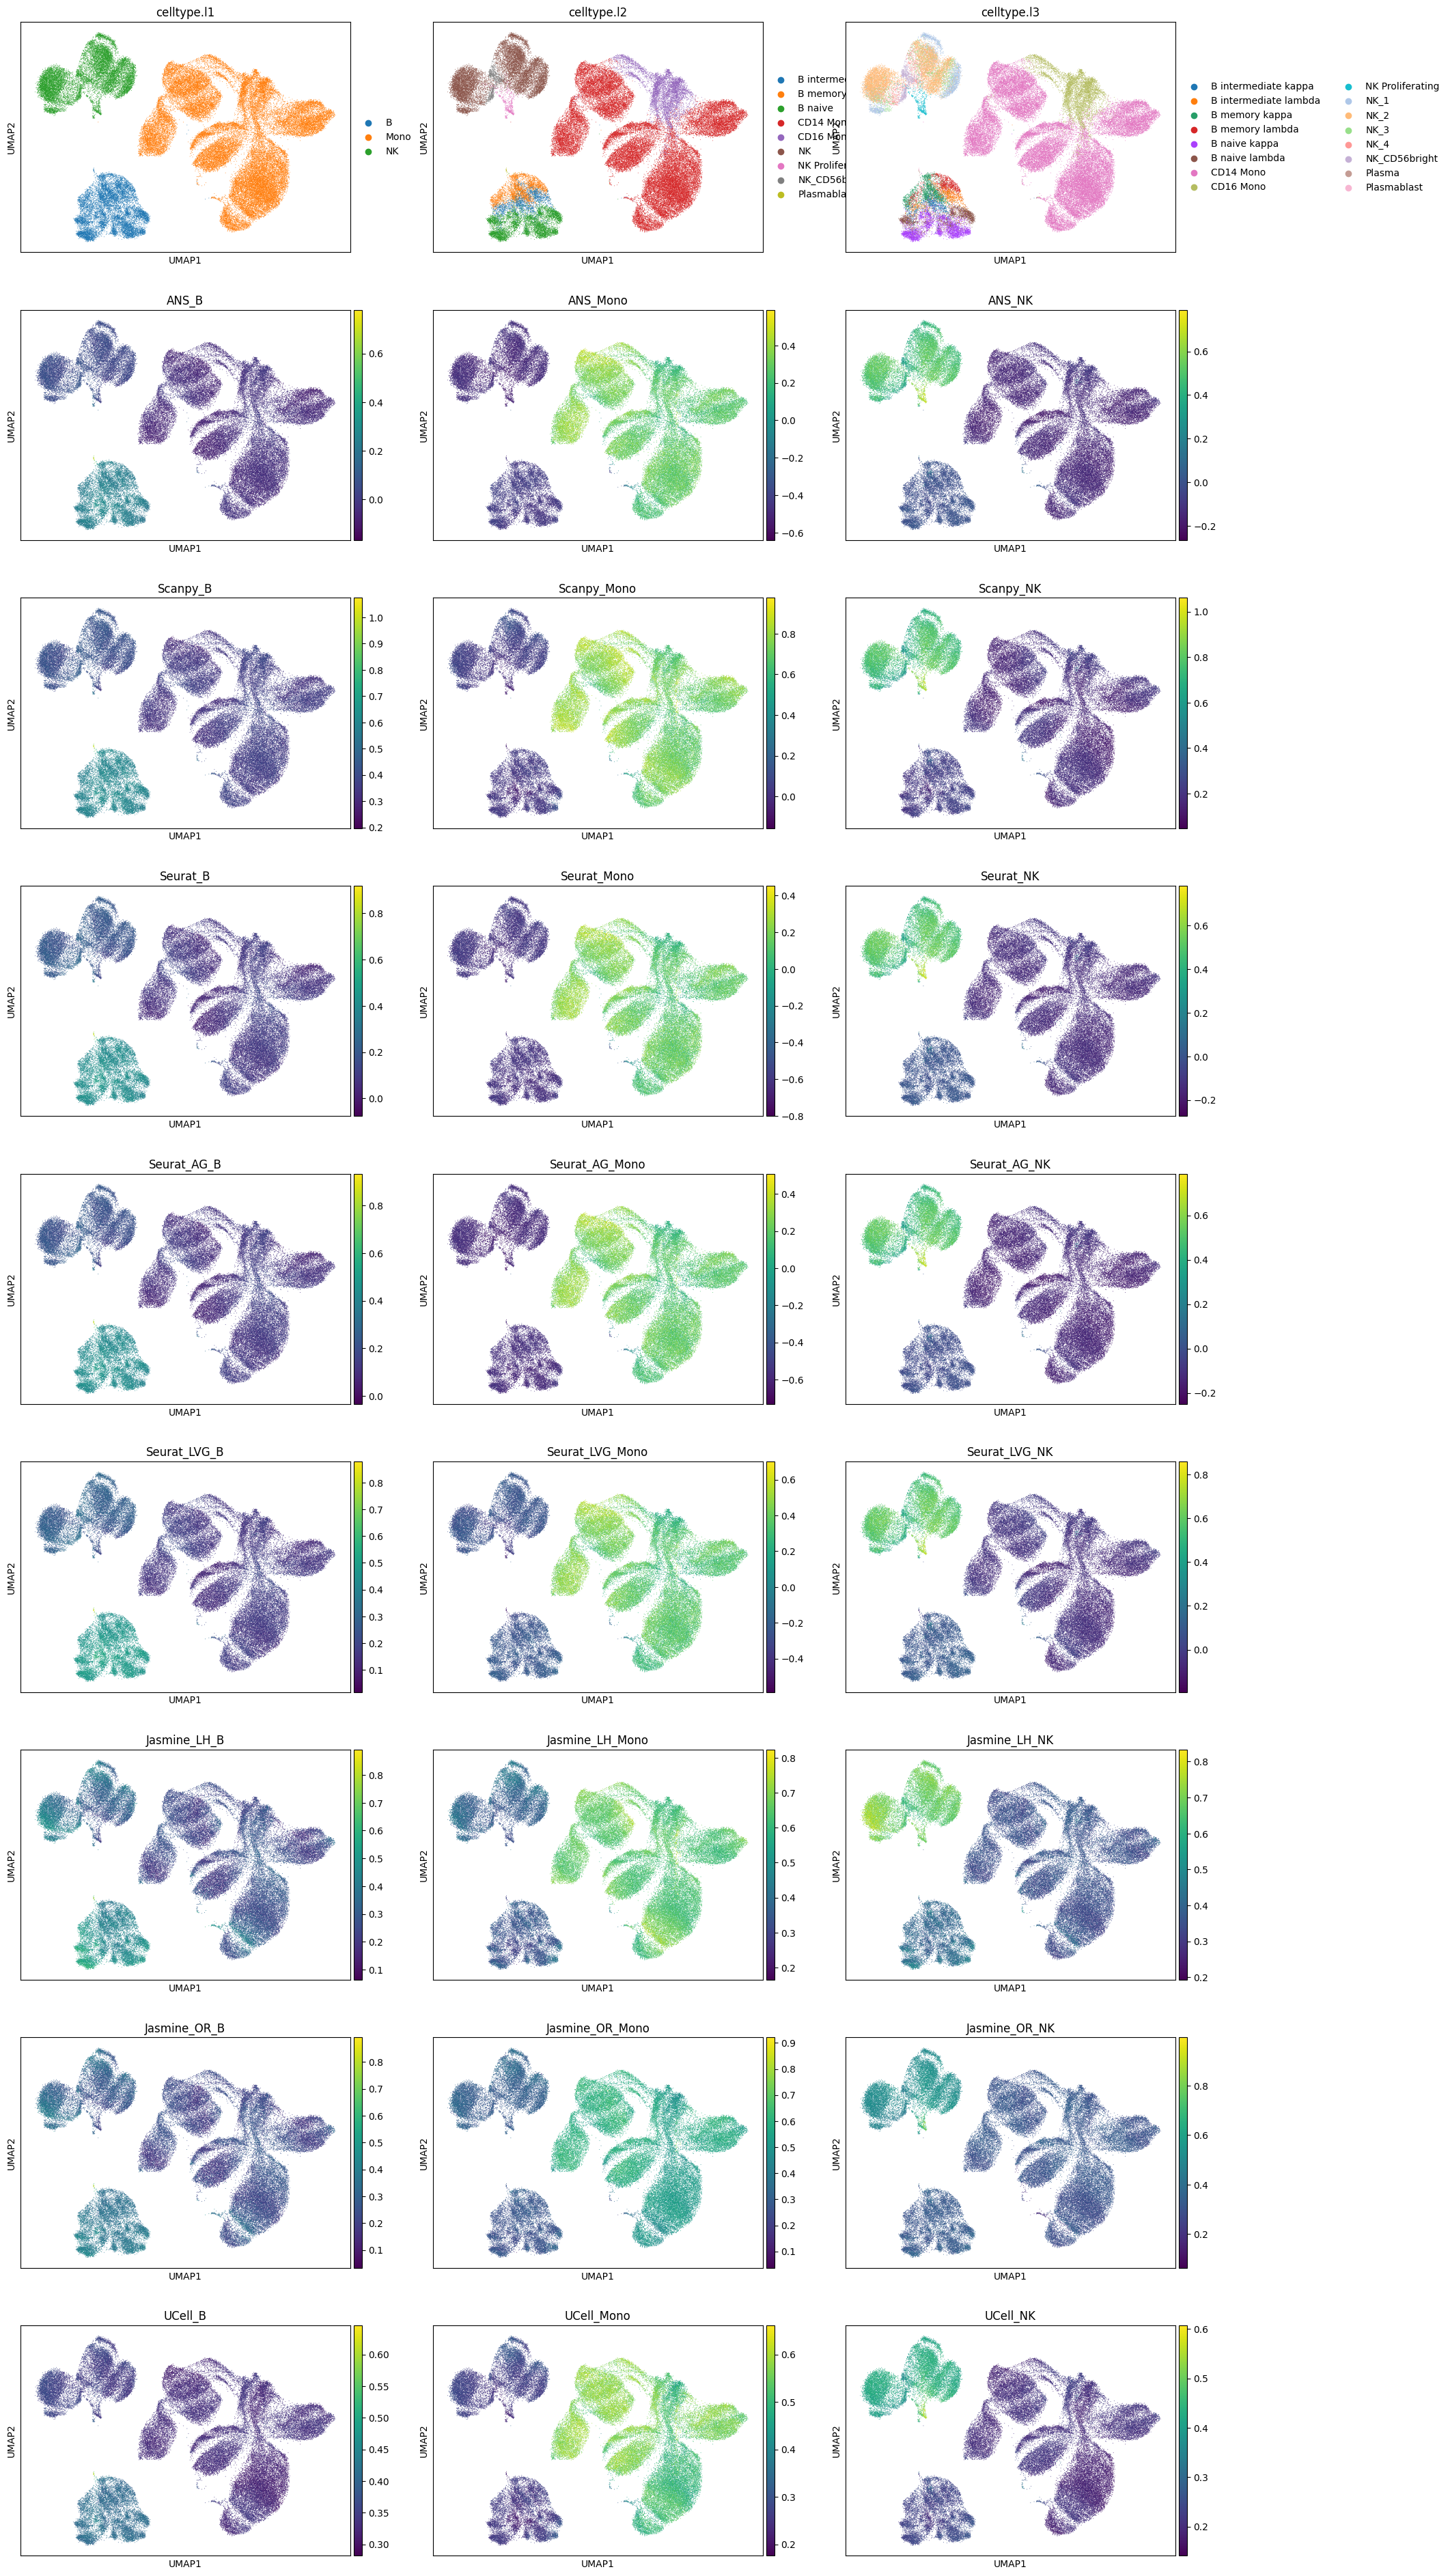

In [19]:
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2', 'celltype.l3']+all_score_names, ncols=3)

## Store adata for following tutorials

In [20]:
adata.write_h5ad('tut_data/pp_pbmc_b_mono_nk_scored.h5ad')